<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap12/annotation%20/Bounding_boxes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
import sys
%load_ext autoreload
%autoreload 2
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
import os
folder = '/content/gdrive/My Drive/school_of_ai/chap12/annotations/'
os.chdir(folder)
print(os.getcwd()) 
for items in os.listdir(folder):
   print(items)
sys.path.append(folder)

/content/gdrive/My Drive/school_of_ai/chap12/annotations
via_export_coco.json
50dogs
Untitled0.ipynb


In [0]:
%matplotlib inline
from __future__ import print_function
import sys
import os
from argparse import Namespace

import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from plotnine import *

In [30]:
os.chdir('/content/gdrive/My Drive/school_of_ai/chap12/annotations/50dogs')
with open('/content/gdrive/My Drive/school_of_ai/chap12/annotations/via_export_coco.json') as f:
  data = json.load(f)

print(data.keys())
images = pd.DataFrame(data['images'], columns = data['images'][0].keys())
annotations = pd.DataFrame(data['annotations'], columns = data['annotations'][0].keys())

dict_keys(['info', 'images', 'annotations', 'licenses', 'categories'])


In [48]:
images.head()

,id,width,height,file_name
0,0,290,290,n02085782_564.jpg
1,1,500,378,n02086240_272.jpg
2,2,400,300,n02086646_309.jpg
3,3,333,500,n02087394_889.jpg
4,4,318,500,n02088094_115.jpg


In [50]:
annotations.head()

,bbwidth,bbheight
0,202,267
1,290,151
2,203,235
3,277,426
4,204,395


Preprocessing - Remove all unnecessary columns, spilt the bbox column


In [33]:
bbwidth = []
bbheight = []
bbx = []
bby = []
bbox = list(annotations['bbox'])
for i in bbox:
    bbx.append(i[0])
    bby.append(i[1])
    bbwidth.append(i[2])
    bbheight.append(i[3])
annotations['bbx'] = bbx
annotations['bby'] = bby
annotations['bbwidth'] = bbwidth
annotations['bbheight'] = bbheight
annotations = annotations.rename(columns={"image_id": "id"})
annotations = annotations.drop(["bbox","bbx","bby","id","segmentation","area","iscrowd"],axis =1)
annotations.head()

,bbwidth,bbheight
0,202,267
1,290,151
2,203,235
3,277,426
4,204,395


In [34]:
images = images.drop(["license","date_captured"],axis = 1)
images.head()

,id,width,height,file_name
0,0,290,290,n02085782_564.jpg
1,1,500,378,n02086240_272.jpg
2,2,400,300,n02086646_309.jpg
3,3,333,500,n02087394_889.jpg
4,4,318,500,n02088094_115.jpg


Concatinate Both the files


In [0]:
finalfile = pd.concat([images,annotations],axis = 1)
finalfile = finalfile.drop(["id"],axis =1)
finalfile.head()
finalfile = finalfile[:-1]

Normalize the image

In [53]:
finalfile['bbwidth'] = finalfile['bbwidth'].div(finalfile['width'])
finalfile['bbheight'] = finalfile['bbheight'].div(finalfile['height'])
finalfile['height'] = finalfile['height'].div(finalfile['height'])
finalfile['width'] = finalfile['width'].div(finalfile['width'])

finalfile.head()

,width,height,file_name,bbwidth,bbheight
0,1.0,1.0,n02085782_564.jpg,0.696552,0.920690
1,1.0,1.0,n02086240_272.jpg,0.580000,0.399471
2,1.0,1.0,n02086646_309.jpg,0.507500,0.783333
3,1.0,1.0,n02087394_889.jpg,0.831832,0.852000
4,1.0,1.0,n02088094_115.jpg,0.641509,0.790000


In [54]:
table_for_algo = finalfile.drop(["width","height","file_name"],axis = 1)
table_for_algo.head()

,bbwidth,bbheight
0,0.696552,0.920690
1,0.580000,0.399471
2,0.507500,0.783333
3,0.831832,0.852000
4,0.641509,0.790000


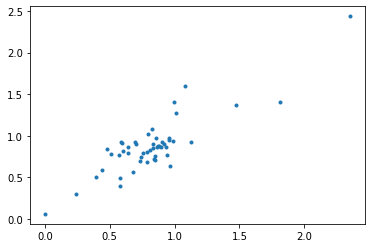

In [55]:
import matplotlib.pyplot as plt
plt.plot(table_for_algo['bbwidth'],table_for_algo['bbheight'],'.')

Apply elbow method to find out k


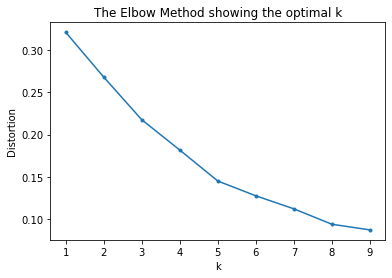

In [56]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(table_for_algo)
    kmeanModel.fit(table_for_algo)
    distortions.append(sum(np.min(cdist(table_for_algo, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) /table_for_algo.shape[0])

# Plot the elbow
plt.plot(K, distortions, '.-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [0]:
height = list(table_for_algo['bbheight'])
width = list(table_for_algo['bbwidth'])
ks = range(1,10)
meaniou = []
for k in ks:
    cl = KMeans(n_clusters=k)
    cl.fit(table_for_algo)
    cx = []
    cy = []
    mapcx  = {}
    mapcy = {}
    iou = []
    for i in range(50):
        
        l = cl.labels_[i]
        cx.append(cl.cluster_centers_[l][0])
        cy.append(cl.cluster_centers_[l][1])
        iou.append(min(width[i] ,cx[i])* min(height[i] , cy[i])/(height[i]*width[i]+ cx[i]*cy[i]- min(width[i] , cx[i])* min(height[i] ,cy[i])))
    meaniou.append(sum(iou)/50)

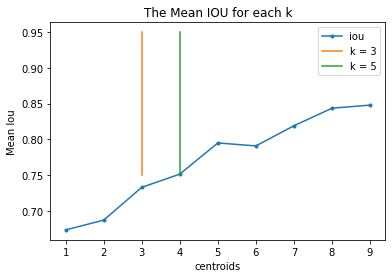

In [58]:
plt.plot(range(1,10),meaniou,'.-',label = "iou")
plt.plot([3,3],[0.75,0.95],label = "k = 3")
plt.plot([4,4],[0.75,0.95],label = "k = 5")
plt.xlabel('centroids')
plt.ylabel('Mean Iou')
plt.title('The Mean IOU for each k')
plt.legend()
plt.show()

In [59]:
meaniou[3],meaniou[4],meaniou[5],meaniou[6]


(0.7512289194635028,
 0.7949027095713324,
 0.7907160782424395,
 0.8189755010832394)

For K = 3

In [65]:
cl3 = KMeans(3)
cl3.fit(array_points)

plt.scatter(cl3.cluster_centers_[:,0] ,cl3.cluster_centers_[:,1], color='red',s = 100,marker = 'o', label='centroids')
plt.scatter(list(table_for_algo['bbwidth']), list(table_for_algo['bbheight']), marker="v",c=list(cl3.labels_.astype(float)), label = "data")
plt.legend()
plt.xlabel('bbwidth')
plt.ylabel('bbheight')
plt.title('K Means for k = 3')
plt.legend()
plt.show()


ValueError: ignored

In [0]:
cl3 = KMeans(3)
#cl3.fit(array_points)

plt.scatter(cl3.cluster_centers_[:,0] ,cl3.cluster_centers_[:,1], color='red',s = 100,marker = 'o', label='centroids')
plt.scatter(list(table_for_algo['bbwidth']), list(table_for_algo['bbheight']), marker="v",c=list(cl3.labels_.astype(float)), label = "data")
plt.legend()
plt.xlabel('bbwidth')
plt.ylabel('bbheight')
plt.title('K Means for k = 3')
plt.legend()
plt.show()
